# Data generation for ART input

Tested using biodesign_3.7 kernel on the jprime.lbl.gov server. It uses the cplex library for running the MOMA optimization

# Content for the library

## Setup

We clone the omg library: 
git clone https://github.com/JBEI/OMG.git --branch omgforallhosts --single-branch

In [9]:
import collections as col
import os
import random
import re
import sys
import cobra
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
sys.path.insert(1, '../OMG')
import omg

## Global parameters

## User parameters

In [11]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': 'models/iJO1366_MVA.json',
    'modelfilepath': 'sample_files',
    'cerevisiae_modelfile': 'iMM904.json',
    'timestart': 0.0,
    'timestop': 8.0,
    'numpoints': 9,
    'designfile': 'training_data_8reactions.csv',
    'designfilepath': 'data',
    'mapping_file': 'mapping/inchikey_to_cid.txt',
    'numreactions': 8,
    'numinstances': 95,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01,
    'BIOMASS_REACTION_ID': 'BIOMASS_Ec_iJO1366_core_53p95M'
} 

-----

# Content for the Jupyter Notebook

-------

Creating a visualization function:

In [12]:
def plot_DO_extmets(od,ext_metabolites):
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    od.plot(ax=ax[0], style='s-', title='Cell', label='dcw', legend=True)
    ax[0].set_xlabel("Hour")
    ax[0].set_ylabel("Concentration (gDW/L)")
    ext_metabolites.plot(ax=ax[1], style='o-', title='External Metabolites')
    ax[1].set_xlabel("Hour")
    ax[1].set_ylabel("Concentration (mM)")

## Using the OMG library functions for creating synthetic multiomics data

### 1) Getting and preparing the metabolic model

First we obtain the metabolic model:

In [13]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)

### Check if isopentenol pathway present in model else add it to the model using the S. Cerevisiae model

In [14]:
if not omg.model_has_IPP_pathway(model):
    print("Isopentenol pathway is present in model")
    sce_filename = user_params['cerevisiae_modelfile']
    try:
        sce_model = cobra.io.load_json_model(sce_filename)
    except IOError:
        print("Could not read file:", sce_filename)
    else:
        # add pathway to model
        omg.add_isopentenol_pathway(model, sce_model)

We now add minimum flux constraints for production of isopentenol and formate, and we limit oxygen intake:

In [15]:
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)
#lac_cons = model.problem.Constraint(model.reactions.EX_lac__D_e.flux_expression,ub = 0.0)
#model.add_cons_vars(lac_cons)
#etoh_cons = model.problem.Constraint(model.reactions.EX_etoh_e.flux_expression,ub = 0.0)
#model.add_cons_vars(etoh_cons)

And then we constrain several central carbon metabolism fluxes to more realistic upper and lower bounds:

In [17]:
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

We also create a similar model with a higher production of isopentenol, which we will use with MOMA to simulate bioengineered strains:

In [18]:
modelHI = model.copy()
iso_cons = modelHI.problem.Constraint(modelHI.reactions.EX_isoprenol_e.flux_expression,lb = 0.25)
modelHI.add_cons_vars(iso_cons)

### 2) Obtaining times series (function A)

Create first time grid for simulation:

In [19]:
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numpoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)

grid =(tspan, delt)

We then use this model to obtain the times series for fluxes, OD and external metabolites:

In [20]:
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    omg.get_flux_time_series(model, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5363612610171477
1.0 optimal 0.5363612610171477
2.0 optimal 0.5363612610171477
3.0 optimal 0.5363612610171477
4.0 optimal 0.5363612610171477
5.0 optimal 0.5363612610171477
6.0 optimal 0.5363612610171477
7.0 optimal 0.5363612610171477
8.0 optimal 0.5363612610171477


In [21]:
Emets

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0,0.102538
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0,0.277855
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0,0.577608
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,0,1.09012
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,0,1.96639
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,0,3.46462
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,0,6.02626
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,0,10.4061
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,0,17.8946
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,0,17.8946


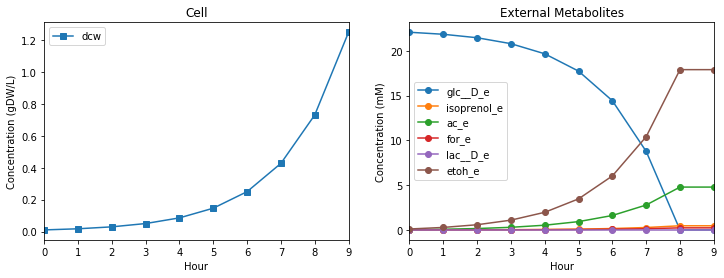

In [22]:
plot_DO_extmets(cell, Emets[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

We can see that some of the internal fluxes are maxed out the upper bound we established above:

In [23]:
for rxn in ['MDH','PTAr','CS','PPC']:
    print(str(rxn)+": "+ ', '.join([str(solution_TS[i].fluxes['CS']) for i in range(len(solution_TS))]))

MDH: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PTAr: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
CS: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PPC: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


We perform the same calculation for the model with higher isoprenol production that we created above:

In [24]:
solutionHI_TS, modelHI_TS, cellHI, EmetsHI, Erxn2EmetHI = \
    omg.get_flux_time_series(modelHI, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5352266385352653
1.0 optimal 0.5352266385352653
2.0 optimal 0.5352266385352653
3.0 optimal 0.5352266385352653
4.0 optimal 0.5352266385352653
5.0 optimal 0.5352266385352653
6.0 optimal 0.5352266385352653
7.0 optimal 0.5352266385352653
8.0 optimal 0.5352266385352653


In [25]:
EmetsHI

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0708,18.6185,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00330624,0.0287831,0.0013225,0.100218,0
1.0,21.8449,18.488,69.4355,1.99517,1.99983,21.8793,103.7,27.2499,0.00895276,0.0779399,0.0035811,0.271374,0
2.0,21.4592,18.265,69.4156,1.98996,1.99965,21.8752,103.7,27.2498,0.0185961,0.161892,0.00743843,0.563679,0
3.0,20.8004,17.8842,69.3816,1.98107,1.99935,21.8683,103.7,27.2496,0.0350653,0.305267,0.0140261,1.06289,0
4.0,19.6753,17.2338,69.3235,1.96588,1.99883,21.8566,103.7,27.2493,0.0631919,0.550129,0.0252768,1.91546,0
5.0,17.7539,16.123,69.2243,1.93994,1.99793,21.8365,103.7,27.2488,0.111228,0.968313,0.0444911,3.3715,0
6.0,14.4724,14.226,69.0549,1.89565,1.99641,21.8022,103.7,27.2478,0.193265,1.6825,0.0773059,5.85819,0
7.0,8.86817,10.9863,68.7655,1.81999,1.99381,21.7437,103.7,27.2463,0.333371,2.90222,0.133348,10.105,0
8.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0
9.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0


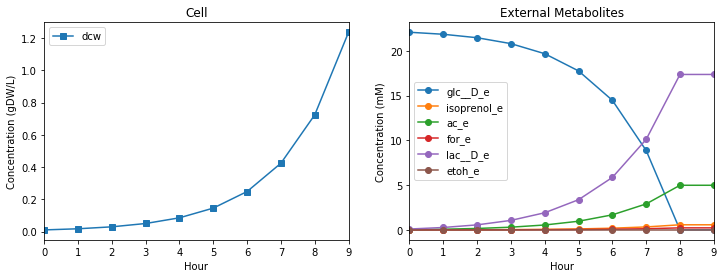

In [26]:
plot_DO_extmets(cellHI, EmetsHI[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

### 3) Getting multiomics data for wild type

We now obtain the multiomics data for each time point:

In [27]:
#for t in tspan:
#    (proteomics, transcriptomics, metabolomics) = get_multiomics(model, solution_TS[t])
proteomics_timeseries = {}
transcriptomics_timeseries = {}
metabolomics_timeseries = {}

for t in tspan:
    proteomics_timeseries[t], transcriptomics_timeseries[t], metabolomics_timeseries[t] = omg.get_multiomics(model, solution_TS[t], user_params['mapping_file'])

### 4) Getting bioengineered flux profiles through MOMA (function B)

First obtain files with suggested designs (i.e. reactions kos and overexpressions):

In [28]:
design_df = pd.read_csv(f'{user_params["designfilepath"]}/{user_params["designfile"]}')

#design_df = design_df.loc[0:4,:] # Truncate this dataframe for faster testing!!!

Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [29]:
design_df.loc[0:1,:]

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,1,1,1,2,0,2,0,0,0
1,2,1,2,2,2,2,1,1,0


We then use MOMA to calculate flux profiles at each time point for the bioengineered strains. Instead of using the solution time series corresponding to the initial model, we use the solution time series corresponding to the higher production. The reason is that, otherwise, we would never see an increase in isoprenol production, since MOMA minimizes the changes in flux by design. Remember that our goal here is just to create realistic flux profiles that can be used to showcase ART. This approach is good enough: 

In [30]:
%%time
solutionsMOMA_TS = {}
if user_params['numinstances'] not in [None, 0]:
    num_strains = user_params['numinstances']
else:
    num_strains = design_df.shape[0]
for i in range(num_strains):
    design = design_df.loc[i,:]
    solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solutionHI_TS, grid)

CPU times: user 4min 52s, sys: 2.3 s, total: 4min 55s
Wall time: 4min 55s


We can check that the knocked out fluxes are zero:

In [31]:
i=0
print(str(design_df.loc[i,:])+'\n')
for rxn in ['CS','PPC','PFL']:
    print(str(rxn)+": "+str(solutionsMOMA_TS[i][5].fluxes[rxn]))

Line Name    1
ACCOAC       1
MDH          1
PTAr         2
CS           0
ACACT1r      2
PPC          0
PPCK         0
PFL          0
Name: 0, dtype: object

CS: 0.0
PPC: 0.0
PFL: 0.0


### 5) Producing the external metabolite concentrations for each bioengineered strain (function D)

Here we use the integrate_fluxes function to produce the external metabolite concentrations compatible with the calculated fluxes:

In [32]:
%%time
cellsEmetsBE = {}
for i in range(num_strains):
    cell, Emets = omg.integrate_fluxes(solutionsMOMA_TS[i], model_TS, user_params['ext_metabolites'], grid, user_params)
    cellsEmetsBE[i] = (cell, Emets) 


CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms


We can check we obtain the same result with this function for the wild type as we did above:

In [33]:
cellWT, EmetsWT = omg.integrate_fluxes(solution_TS, model_TS, user_params['ext_metabolites'], grid, user_params)

In [34]:
EmetsWT

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0,0.102538
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0,0.277855
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0,0.577608
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,0,1.09012
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,0,1.96639
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,0,3.46462
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,0,6.02626
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,0,10.4061
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,0,17.8946
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,0,17.8946


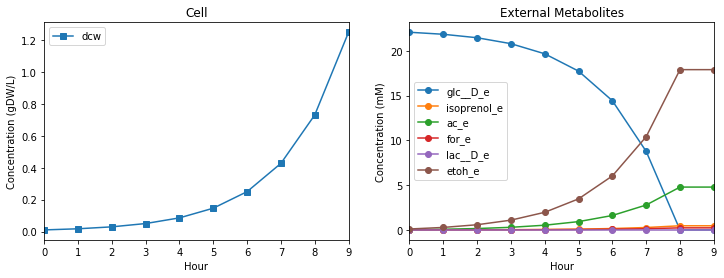

In [35]:
plot_DO_extmets(cellWT, EmetsWT[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

And compare with any other bioengineered strain:

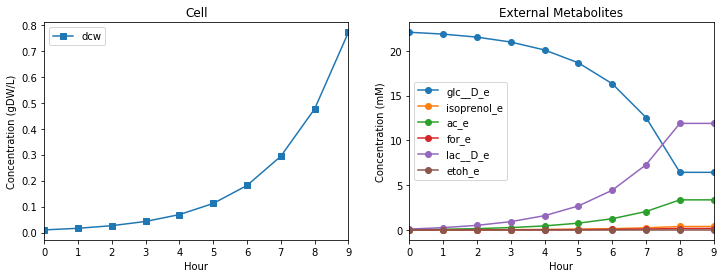

In [37]:
i = 2
cellBE, EmetsBE = cellsEmetsBE[i]
plot_DO_extmets(cellBE, EmetsBE[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

In [38]:
EmetsBE

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0745,18.6206,69.448,1.99814,1.99995,21.8818,103.7,27.25,0.00311532,0.0273521,0.00128548,0.0969536,0
1.0,21.8661,18.4999,69.4382,1.99514,1.99986,21.8798,103.7,27.2499,0.00816443,0.0716826,0.00336891,0.25409,0
2.0,21.5284,18.3044,69.4223,1.99026,1.99972,21.8766,103.7,27.2498,0.0163475,0.14353,0.00674559,0.508765,0
3.0,20.9812,17.9874,69.3966,1.98236,1.99949,21.8715,103.7,27.2497,0.0296101,0.259976,0.0122183,0.921525,0
4.0,20.0942,17.4738,69.3549,1.96955,1.99912,21.8631,103.7,27.2495,0.0511057,0.448704,0.0210881,1.5905,0
5.0,18.6566,16.6413,69.2873,1.9488,1.99851,21.8496,103.7,27.2491,0.0859442,0.754582,0.0354636,2.67473,0
6.0,16.3268,15.292,69.1779,1.91516,1.99754,21.8276,103.7,27.2485,0.142408,1.25033,0.0587625,4.43197,0
7.0,12.5506,13.1052,69.0004,1.86065,1.99596,21.792,103.7,27.2476,0.233921,2.0538,0.0965237,7.28,0
8.0,6.43053,9.56095,68.7128,1.77229,1.99339,21.7343,103.7,27.246,0.382239,3.35601,0.157725,11.8959,0
9.0,6.43053,9.56095,68.7128,1.77229,1.99339,21.7343,103.7,27.246,0.382239,3.35601,0.157725,11.8959,0


### 6) Creating final data frame for training ART

Collect all isoprenol production values in a single list first:

In [45]:
production = []
for i in range(user_params['numinstances']):
    cell, Emets = cellsEmetsBE[i]
    production.append(Emets.loc[9,'isoprenol_e'])
print(production)

[0.0,
 0.5518867749304419,
 0.3822393923183627,
 0.5515996641755987,
 0.09795262257973388]

Create new data frame and append the production

In [40]:
production_df = design_df

In [47]:
production_df['Production']=production.copy()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Production
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.551887
2,3,1,0,0,2,1,1,2,0,0.382239
3,4,1,1,1,1,2,2,1,0,0.551600
4,5,2,0,2,1,1,0,1,1,0.097953


In [48]:
production_df.loc[0:2,:]

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Production
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.551887
2,3,1,0,0,2,1,1,2,0,0.382239


In [49]:
np.max(production_df['Production'])

0.5518867749304419

Save data frame as csv:

In [50]:
production_df.to_csv('ART_training.csv')

In [51]:
production_df

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Production
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.551887
2,3,1,0,0,2,1,1,2,0,0.382239
3,4,1,1,1,1,2,2,1,0,0.551600
4,5,2,0,2,1,1,0,1,1,0.097953


----

----

----